In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm.auto import tqdm

import PIL
from PIL import Image
import rasterio

import scipy.stats as stats

from pyrosm import OSM
from pyrosm import get_data

/var/folders/pj/pdfdfscs3hjg6dyzhnb84n_80000gn/T/ipykernel_85607/2853333260.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [5]:
tif_file = rasterio.open('population/population_heatmap.tif')
heatmap = tif_file.read() + 200
heatmap /= heatmap.max()
heatmap = heatmap.squeeze(0)

In [6]:
print(heatmap.shape)
print(heatmap.min())
print(heatmap.max())

(18000, 36082)
0.0
1.0


In [79]:
heatmap_img = np.uint8(heatmap * 255).squeeze(0)
print(heatmap_img.shape)
heatmap_img = Image.fromarray(heatmap_img)
heatmap_img.resize((512, 512))
heatmap_img.show()

In [86]:
from multiprocessing import Process
from gen_points import gen_points
for i in range(8, 12):
    t = Process(target=gen_points, args=(heatmap, i))
    t.start()

Predicting
Predicting(1.00%)
Predicting(2.02%)
Predicting(0.98%)


In [ ]:
gpd.datasets.get_path('naturalearth_lowres')

'/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp'

In [119]:
points = np.load('points_00.npy')
points /= 100
points[:, 0] -= 180
points[:, 1] -= 90
points[:, 1] *= -1
points *= 10**5

In [120]:
points.max()

17119000.0

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world = world[(world.pop_est>0) & (world.name!="Antarctica")]
# world = world.iloc[world.idx == 0]

coords_df = gpd.GeoDataFrame(geometry=[Point(point[0], point[1]) for point in points])
coords_df.crs = 'ESRI:54009'
coords_df.to_crs(world.crs, inplace=True)
print(world.crs)


EPSG:432600 (56.94%)


<AxesSubplot: >

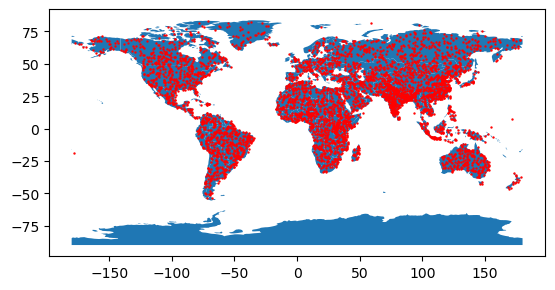

In [122]:
world_plot = world.plot()
coords_df.plot(ax=world_plot, marker='o', color='red', markersize=0.5)

In [3]:
# Initialize the OSM parser object
# for point in coords_df.geometry:
point = coords_df.geometry[0]
x, y = point.x, point.y
osm = OSM('planet.osm.pbf', bounding_box=[x+0.1, y+0.1, x-0.1, y-0.1])
drive_net = osm.get_network(network_type="driving")


OSM data loaded


In [13]:
drive_net.sindex

In [109]:
offset = 0.1
coords = Point(26.95, 60.53)
# bbox = [coords[0]-offset, coords[1]-offset, coords[0]+offset, coords[1]+offset]

In [110]:
drive_net.sindex.nearest(coords)


array([[0],
       [3]])

In [111]:
# line = drive_net.iloc[175].geometry.union
line = drive_net.geometry.unary_union
# print(line)

/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


In [118]:
%time rectified_coords = line.interpolate(line.project(coords))

CPU times: user 171 µs, sys: 263 µs, total: 434 µs
Wall time: 344 µs


In [116]:
coords_df

,name,geometry
0,Original,POINT (26.95000 60.53000)
1,Rectified,POINT (26.95049 60.52938)


In [114]:
print(drive_net.crs)

epsg:4326


<AxesSubplot: >

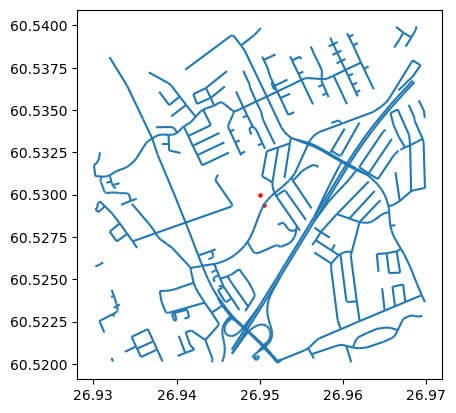

In [117]:
drive_net_plot = drive_net.plot()
coords_df = gpd.GeoDataFrame({'name': ['Original', 'Rectified'], 'geometry': [coords, rectified_coords]})
coords_df.crs = drive_net.crs
coords_df.plot(ax=drive_net_plot, marker='o', color='red', markersize=5)